# Tutorial 2: Fit an extreme value distribution for the water level
This example shows how to fit an extreme value probability distribution from data of water levels and their return periods.
This notebook consists of the following steps:
1. Importing packages and data
2. Importing the data from an external source
3. Preprocessing the data
4. Visually checking the data
5. Fitting a Generalized Extreme Value (GEV) distribution
6. Optimizing the distribution parameters using Python
7. Plotting the result
8. Force fitting a Gumbel distribution

## Step 1: Importing packages and data
In the next cell, we import the python packages necessary to run this tutorial.
We also print the versions.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev
from scipy.optimize import minimize
print("numpy version {}".format(np.__version__))
print("scipy version {}".format(sp.__version__))
print("pandas version {}".format(pd.__version__))

c:\Users\smyrniou\AppData\Local\pypoetry\Cache\virtualenvs\d-geolib-plus-kMHGCWnf-py3.10\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


numpy version 1.26.2
scipy version 1.9.3
pandas version 1.5.3


## Step 2: Importing the data from external source
To import the data, we specify the file path, and import the file with the data.
The data is automatically stored in a Pandas Dataframe.

Download the file from <a href="../../_static/input_waterlevels_returnperiod.txt" download>input_waterlevels_returnperiod.txt</a>

In [2]:
# Use Pandas to import the csv file. The headers are taken as column names
df = pd.read_csv("../../_static/input_waterlevels_returnperiod.txt", sep=",")

## Step 3: Preprocessing of the data.
To fit a probability distribution, we need to do some preprocessing. 
We need to calculate a probability of exceedance from the return period.

The frequency of exceedance is $f = 1/T$ per year, and is calculated for each water level $h$. 

The probability of exceedance is calculated as follows: $P(h>H)=1-\exp(-f)$ to prevent probabilities larger than 1 for frequencies larger than 1 per year.

In [3]:
# Compute the freqency per yearand add it to the dataframe
df['FrequencyPerYear'] = 1/df['ReturnPeriod']
# Compute the exceedance probabilities from the frequency. 
df['ExceedanceProbability'] = 1-np.exp(- df['FrequencyPerYear'])
# Sort the water levels in ascending order
df.sort_values('WaterLevel', ascending=True)

,ReturnPeriod,WaterLevel,FrequencyPerYear,ExceedanceProbability
0,1,3.50,1.000000,0.632121
1,10,5.06,0.100000,0.095163
2,30,5.64,0.033333,0.032784
3,50,5.83,0.020000,0.019801
4,100,6.03,0.010000,0.009950
5,300,6.26,0.003333,0.003328
6,1000,6.44,0.001000,0.001000
7,3000,6.56,0.000333,0.000333
8,10000,6.67,0.000100,0.000100
9,30000,6.76,0.000033,0.000033


## Step 4: Visually checking the data
Now we have the data points with the water level and the exceedance probability for that water level. We plot the datapoints on a logarithmic y-scale to judge if the data is logical. 

The data in this example seems logical, viz. the exceedance probabilities monotonously decrease with the waterlevel. Morover, we observe that the last 5 points are rather linear (on a logarithmic scale), and there seems to be a bend/kink in the data around a water level of 6.25 m.

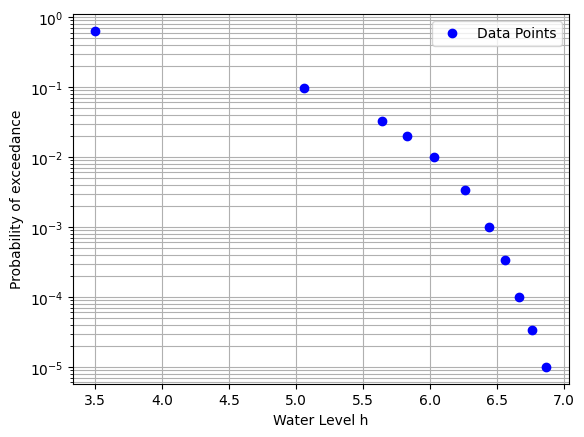

In [4]:
def plot_waterdata(ax):
    '''
    Create a funtion to plot the waterdata, so we can later acess it again
    '''
    ax.semilogy(df['WaterLevel'], 
                df['ExceedanceProbability'], 
                'bo', label='Data Points')
    ax.set_xlabel('Water Level h')
    ax.set_ylabel('Probability of exceedance')
    ax.grid(which='both')
    ax.legend()

ax = plt.subplot()
plot_waterdata(ax)
plt.show()

## Step 5: Fitting a Generalized Extreme Value (GEV) distribution
Now we fit an extreme value distribution. We choose the Generalized Extreme Value distribution. 

We want to set the parameters of a GEV distribution such that the cdf fits the data points. We can make a few tries and see how this works out. With a few manual iterations, the result would not too bad after all.

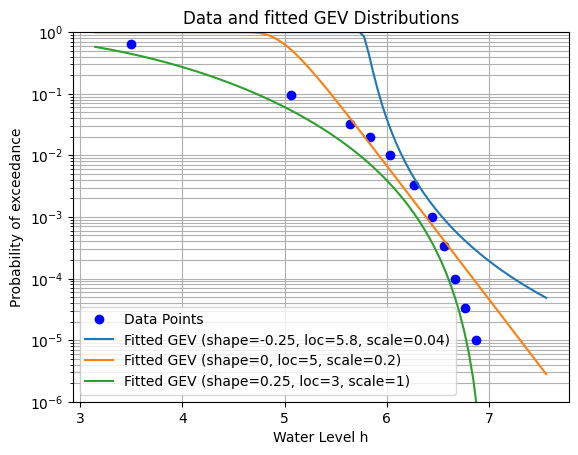

Note the opposite convention of the sign of the shape parameter c in scipy, compared to several other sources (e.g. Wikipedia) and software packages (Probabilistic Toolkit).


In [5]:
def plot_GEV_cdf(ax, distribution_parameters):
    '''
    Create a funtion to plot the cdf, so we can later acess it again
    '''
    # Define a range of water levels for our fits
    # Base the bounds on the minimum and maximum of the data points.
    h_plotting_range = np.linspace(df['WaterLevel'].min()*0.9, 
                                   df['WaterLevel'].max()*1.1, 100)

    # For each guess, we calculate the cdf values for the given range
    p_exc_fit = gev.cdf(h_plotting_range, 
                        c = distribution_parameters['shape'], 
                        loc = distribution_parameters['location'], 
                        scale = distribution_parameters['scale'])

    # And plot the exceedance probability = 1 - cdf 
    ax.semilogy(h_plotting_range, 
                 1-p_exc_fit, 
                 label='Fitted GEV (shape={:.3g}, loc={:.3g}, scale={:.3g})'.format(
                     distribution_parameters['shape'],
                     distribution_parameters['location'],
                     distribution_parameters['scale']))
            
# Re-instantiate the previous figure
ax = plt.subplot()
plot_waterdata(ax)

# We define different guesses for the shape, location, and scale parameter. 
# Note we have a Frechet (shape<1,), Gumbel (shape=0), and Weibull (shape>1). 
# Note that the opposite convention of the sign of the shape parameter in scipy, compared 
# to several other sources (e.g. Wikipedia) and software packages (Probabilistic Toolkit).
distribution_parameters_list = [ 
    {'shape':-0.25, 'location':5.8, 'scale':0.04}, # Frechet
    {'shape':0.00, 'location':5.0, 'scale':0.2},   # Gumbel
    {'shape':0.25, 'location':3.0, 'scale':1.0}]   # Weibull
                                  
# For each guess (distribution_parameter_set in distribution_parameter_set_list), 
# calculate the cdf and plot it.
for distribution_parameters in distribution_parameters_list:
    plot_GEV_cdf(ax, distribution_parameters)

# Adjust the limits, and add labels
plt.ylim([1e-6,1])
plt.title('Data and fitted GEV Distributions')
plt.legend()
plt.savefig('GEV-fit.png', bbox_inches='tight')
plt.show()
print('Note the opposite convention of the sign of the shape parameter c in scipy, compared to several other sources (e.g. Wikipedia) and software packages (Probabilistic Toolkit).')

## Step 6: Optimizing the distribution parameters using Python
To optimize the distribution parameters, we create a loss function `square_log_err`. We define the loss as the squared difference between the $P_{exc}$ of the fitted GEV, and the $P_{exc}$ of the data points. The loss depends on the distribution parameters of the GEV. We take the logarithmic value of the differense, to prevent data points in the tail having a negligible weigth. 

The `scipy.minimize` function is used with an initial guess and bounds for the distribution parameters to get the best combination of parameters, for which the squared difference is the smallest.

In [6]:
def square_log_err(params,):
    '''
    This function defines the sum of the squared log-differences 
    between P_exc of the fitted GEV, and the P_exc of the data points.
    Note that we use gev.sf as the survival function (=1-cdf), 
    and gev.logsf as the log of the survival function (=np.log(1-cdf)), 
    because it is numerically more accurate with values close to 0.0/1.0. 
    '''
    shape, loc, scale = params
    data_h=df['WaterLevel'].iloc[:]
    data_p=df['ExceedanceProbability'].iloc[:]
    log_pexc_fit = gev.logsf(data_h, c=shape, loc=loc, scale=scale)
    log_err =  log_pexc_fit - np.log(data_p)
    return np.sum(log_err**2)

# The minimization needs an initial guess for the parameters
# and bounds for the distribution parameters.
initial_guess = [0.25, 3.0, 1.0]
bounds=[(-1,1),(1,8),(0.01,5)]

# Minimize squared difference to optimize the fit of the GEV distribution
result_gev = minimize(square_log_err, initial_guess, bounds=bounds)

# Extract the fitted parameters
fitted_shape, fitted_location, fitted_scale = result_gev.x
print("Fitted GEV: Shape, Location, Scale: {:.3g} {:.3g} {:.3g}".format(
    fitted_shape, fitted_location, fitted_scale))
print("Note that for use in several other software packages (e.g. \n"
"Probabilistic Toolkit), the opposite convention of the sign of \n"
"the shape parameter c is used.")

Fitted GEV: Shape, Location, Scale: 0.231 3.86 0.743
Note that for use in several other software packages (e.g. 
Probabilistic Toolkit), the opposite convention of the sign of 
the shape parameter c is used.


## Step 7: Plot the result
We show the cdf of the GEV with the optimized parameters in a graph

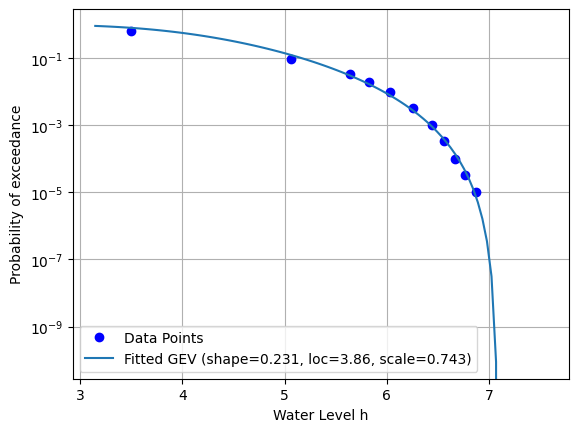

In [7]:
# Re-instantiate the figure with water data
ax = plt.subplot()
plot_waterdata(ax)
distribution_parameters = {'shape':fitted_shape, 
                           'location':fitted_location, 
                           'scale':fitted_scale}
plot_GEV_cdf(ax, distribution_parameters)
plt.legend()
plt.show()

## Step 8: Force fitting a Gumbel distribution
Finally, we consider if we can fit a Gumbel distrubtion using only the last 5 data points. The main reason is that these last 5 points seem rather linear on a log-scale. A Gumbel distribution is a special occasion of a GEV, which has shape parameter 0, and therefore is linear on logarithmic scale. We might want to do this if only the tail of the distribution is important. 

A Gumbel distribution has shape parameter 0, so we put this as a constraint for the mimization by adjusting the bounds.

Note that we also adjust the loss function, so it uses only the last 5 points! 

Fitted Gumbel: Shape, Location, Scale: 0 5.81 0.0923


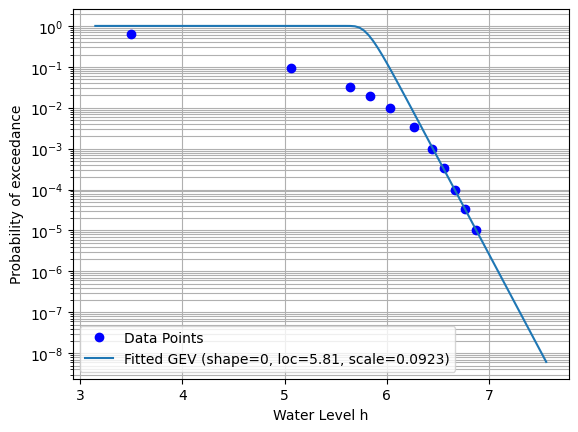

In [8]:
# For a Gumbel distribution, the shape parameter = 0, so adjust the bounds
initial_guess = [0.0, 6.0, 0.1]
bounds=[(0,0),(1,8),(0.01,1)]

def square_log_err(params,):
    '''
    Define the logarithmic difference again. 
    However, note that only the last 5 datapoints are used
    '''
    shape, loc, scale = params
    data_h=df['WaterLevel'].iloc[-5:]
    data_p=df['ExceedanceProbability'].iloc[-5:]
    log_pexc_fit = gev.logsf(data_h, shape, loc=loc, scale=scale)
    log_err =  log_pexc_fit - np.log(data_p)
    return np.sum(log_err**2)

# Make the fit
result_gumbel = minimize(square_log_err, initial_guess, bounds=bounds)
fitted_shape_gumbel, fitted_location_gumbel, fitted_scale_gumbel = result_gumbel.x
print("Fitted Gumbel: Shape, Location, Scale: {:.3g} {:.3g} {:.3g}".format(
    fitted_shape_gumbel, fitted_location_gumbel, fitted_scale_gumbel))

# Re-instantiate the figure with water data
ax = plt.subplot()
plot_waterdata(ax)
distribution_parameters = {'shape':fitted_shape_gumbel, 
                           'location':fitted_location_gumbel, 
                           'scale':fitted_scale_gumbel}
plot_GEV_cdf(ax, distribution_parameters)
plt.legend()
plt.show()